In [1]:
%run ../../_setup.py

import numpy as np
from xarray import open_dataset, DataArray
import pyproj

from gsw import f

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cmocean as cmo

import string

In [2]:
def Rsquared(var_x, var_y, deg=1, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    mask = np.zeros(mask_x.shape, dtype=bool) if mask is None else mask
    mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], deg)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

In [20]:
savefig = False

fs_small = 12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [4]:
# load ctd data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = open_dataset(input_file_ctd)

# load altimetry/ ssh data
input_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_gw.nc')
ssh = open_dataset(input_file_gw)

# load gradient wind data
gw = open_dataset(input_file_gw, group='GW')

# load quasi-geostrophic vorticity terms
input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_qgvb.nc')
qgvb = open_dataset(input_file_qgvb, group='QGVB')

input_file_qgvb = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_qgvb_ctd.nc')
qgvb_ctd = open_dataset(input_file_qgvb, group='CTD')

# load bathymetry
input_file = os.path.join(datadir, 'external', 'bathymetry', 'gebco_2019', 'bodc_res30sec', 
                          'GEBCO_2014_2D_137.0_-58.0_147.0_-48.0.nc')
bathy = open_dataset(input_file)

In [5]:
# transform polar in cartesian coordinate system
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 135 #137
south = -53.4 #-52.4
east = 149 #147
north = -47 #-48

# select time
timevoy = slice('1998-03-12', '1998-03-28')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))
loni, lati = gw.longitude.data, gw.latitude.data

lnln, ltlt = np.meshgrid(loni, lati)
xx, yy = pyproj.transform(WGS84, UTM54, lnln, ltlt)

try:
    dep = bathy.sel(longitude=slice(west, east), latitude=slice(north, south))
    lonH, latH = dep.longitude, dep.latitude
except:
    # boundaries
    west = 135 #137
    south = -47 #-48
    east = 149 #147
    north = -53.4 #-52.4
#     south = -47
#     north = -53.4

    dep = bathy.elevation.sel(lon=slice(west, east), lat=slice(north, south))
    lonH, latH = dep.lon, dep.lat

lnlnH, ltltH = np.meshgrid(lonH, latH)

# transect stations
transects = {1: list(range(3, 11)), 2: list(reversed(range(11, 19))), 3: list(range(19, 28)),
         4: list(reversed(range(27, 35))), 5: list(range(37, 47)), 6: list(reversed(range(47, 58))),
         7: list(range(57, 66)), 8: list(range(69, 77)), 9: list(reversed(range(77, 85))),
         10: list(range(85, 92)), 11: list(reversed([94, 93] + list(range(95, 102))))}

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [6]:
# determine planetary vorticity
fcor = DataArray(f(ltlt), dims=['latitude', 'longitude'], coords=[ssh.latitude, ssh.longitude])
beta = np.gradient(fcor)[0] / np.gradient(yy)[0]
fcorH = f(ltltH)

# ageostrophic velocities
ua, va = (gw.ugrad - gw.ugeos), (gw.vgrad - gw.vgeos)


In [7]:
ssh_contours = np.linspace(-0.4, 0.6, 11)
depth_contours = np.linspace(-5000, -1000, 5)
manual = [(144, -52), (144, -51.5), (145, -51), (145, -50), (145, -48.6)]

In [8]:
# from scipy.interpolate import griddata

# values = dep.values.flatten()
# points = (lnlnH.flatten(), ltltH.flatten())

# H = griddata(points, values, (lnln, ltlt), method='linear')

# plt.pcolormesh(loni, lati, H)

# plot depth contours
# fig, ax = plt.subplots()
# conf = ax.contourf(lnlnH, ltltH, dep, np.linspace(-5000, -1000, 9), 
#                    cmap=plt.cm.binary_r, alpha=0.3)
# dc = ax.contour(lnlnH, ltltH, dep, depth_contours, 
#                    colors='k', linewidths=0.2, linestyles='solid')
# fig.colorbar(conf)


# ax.clabel(dc, depth_contours, inline=1, fontsize=8, fmt='%.0f')

## Barotropic potential vorticity

In [9]:
pvterms = [r'$f/H$', r'$\overline{\zeta}$', r'$\overline{\zeta} + f$', r'$\overline{\zeta}/f$']

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  This is separate from the ipykernel package so we can avoid doing imports until
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the q

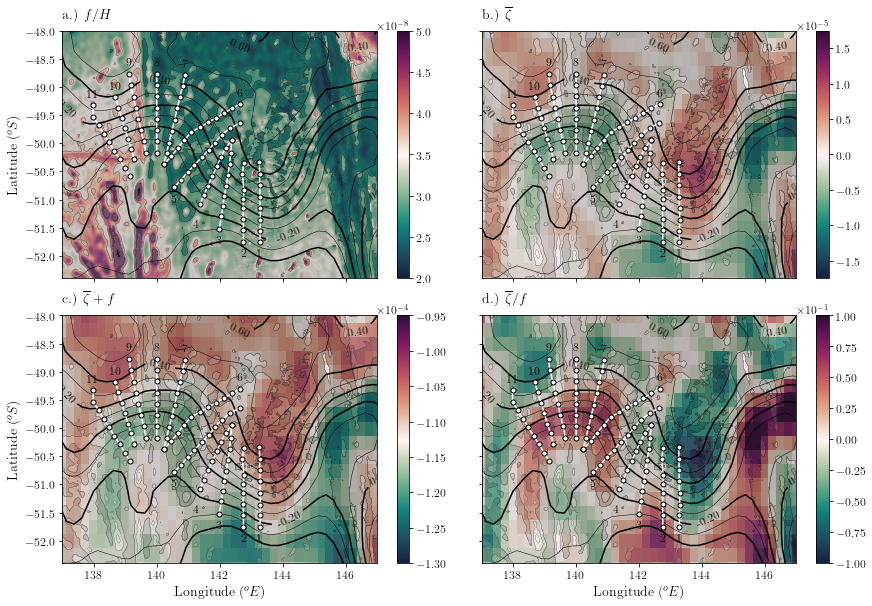

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), 
                       sharex=True, sharey=True, constrained_layout=True)
fig.tight_layout()
fig.subplots_adjust(hspace = 0.15)
# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0, 0].pcolor(lonH, latH, fcorH/dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
# cbar.ax.set_ylabel(r'$f/H$', fontsize=fs_large)
# ax[0, 0].set_title('Barotropic potential vorticity $f/H$')

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[0, 1].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0, 1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
# cbar.ax.set_ylabel(r'$\overline{\zeta}$', fontsize=fs_large)
# ax[0, 1].set_title(r'Mean relative vorticity, $\overline{\zeta}$')

# mean absolute vorticity
vmin, vmax = -0.95e-4, -1.3e-4
pcol = ax[1, 0].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time') + fcor, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
# cbar.ax.set_ylabel(r'$\overline{\zeta} + f$', fontsize=fs_large)
# ax[1, 0].set_title(r'Mean absolute vorticity, $\overline{\zeta} + f$')

# mean relative vorticity advection
vmin, vmax = -1e-1, 1e-1
pcol = ax[1, 1].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time') / fcor, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1, 1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
# cbar.ax.set_ylabel(r'$\overline{\zeta}/f$', fontsize=fs_large)
# ax[1, 1].set_title(r'Quasi-geostrophy assumption ($\zeta/f \ll 1$)')

iax = 0
row, col = ax.shape
for r in range(row):
    for c in range(col):    
        # plot sea surface height contours
        ct = ax[r, c].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'),
                              ssh_contours, colors='k', linestyles='solid', linewidths=0.5)

        for ib, b in enumerate(ssh_contours):
            if b in ssh_contours[0::2]:
                zc = ct.collections[ib]
                plt.setp(zc, linewidth=1.5)
        ax[r, c].clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

        # plot depth contours
        ax[r, c].contourf(lnlnH, ltltH, dep, depth_contours, 
                           cmap=plt.cm.binary_r, alpha=0.3)
        dc = ax[r, c].contour(lnlnH, ltltH, dep, depth_contours, 
                           colors='k', linewidths=0.2, linestyles='solid')
#         ax[r, c].clabel(dc, depth_contours, inline=1, fontsize=8, fmt='%.0f')

        # plot transects
        for transect in transects.keys():
            istations = np.array(transects[transect]) - 1
            ax[r, c].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 
                          'w.-', markersize=10, markeredgecolor='k')
        ts = {1:2, 2:17, 3:18, 4:34, 5:36, 6:46, 7:64, 8:75, 9:76, 10:90, 11:93}
        for its in ts.keys():
            spacing = 0.2 if its > 5 else -0.2
            ax[r, c].text(s=str(its), x=ctd['lon'][ts[its],0], y=ctd['lat'][ts[its],0]+spacing, 
                          ha='center', va='center', fontsize=fs_small)

        
        ax[r, c].set_xlim([137, 147])
        ax[r, c].set_ylim([-52.4, -48])

        # plot labels
        ax[r, c].text(0, 1.05, string.ascii_lowercase[iax] + '.) ' + pvterms[iax], 
                      transform=ax[r, c].transAxes, size=fs_large, weight='bold')
        if r == 1:
            ax[r, c].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
        else:
            plt.setp(ax[r, c].get_xticklabels(), visible=False)
        if c == 0:
            ax[r, c].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
        else:
            plt.setp(ax[r, c].get_yticklabels(), visible=False)
        iax += 1

In [11]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '07_potential-vorticity-terms' + extension),
                   transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have th

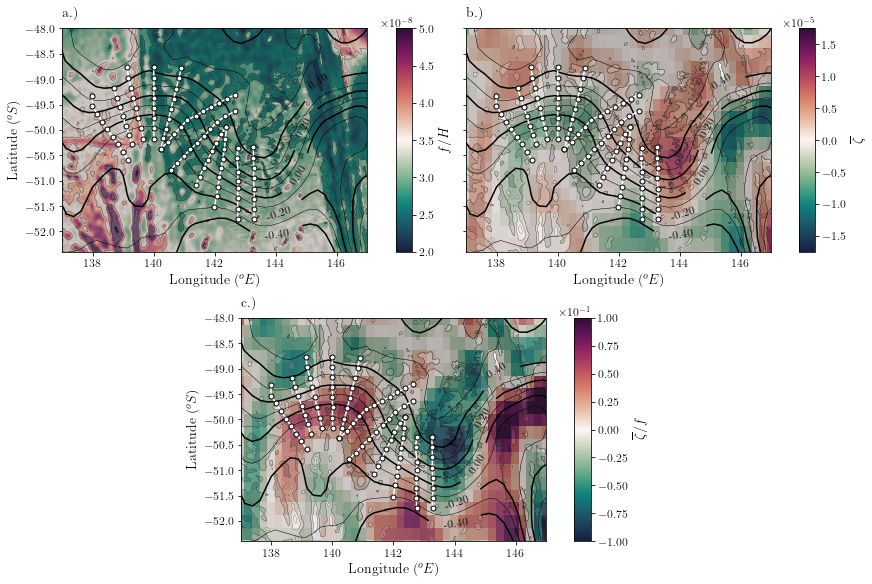

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(12,8))
gs = fig.add_gridspec(ncols=4, nrows=4)
fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, 1:3])
ax = fig.get_axes()

# barotropic potential vorticity
vmin, vmax = 2e-8, 5e-8
pcol = ax[0].pcolor(lonH, latH, fcorH / dep,
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.set_ylabel(r'$f/H$', fontsize=fs_large)

# mean relative vorticity
vmin, vmax = -1.75e-5, 1.75e-5
pcol = ax[1].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.set_ylabel(r'$\overline{\zeta}$', fontsize=fs_large)


# ratio relative / planetary vorticity
vmin, vmax = -1e-1, 1e-1
pcol = ax[2].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time') / fcor, 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[2])
cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.ax.set_ylabel(r'$\overline{\zeta}/f$', fontsize=fs_large)

# # mean absolute vorticity
# vmin, vmax = -0.95e-4, -1.3e-4
# pcol = ax[2].pcolor(ssh.longitude, ssh.latitude, qgvb.zeta.sel(time=timevoy).mean('time') + fcor, 
#                        vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[2])
# cbar.formatter.set_powerlimits((0, 0))
# cbar.update_ticks()
# ax[2].set_title(r'Time-mean absolute vorticity, $\overline{\zeta} + f$')

for iax in range(len(ax)):

    # plot dynamic height contours
    ct = ax[iax].contour(ssh.longitude, ssh.latitude, 
                              ssh.adt.sel(time=timevoy).mean('time'), 
                              ssh_contours, colors='k', linestyles='solid', linewidths=0.5)
    for ib, b in enumerate(ssh_contours):
        if b in ssh_contours[0::2]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[iax].clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)

    # plot depth contours
    ax[iax].contourf(lnlnH, ltltH, dep, depth_contours, 
                       cmap=plt.cm.binary_r, alpha=0.3)
    dc = ax[iax].contour(lnlnH, ltltH, dep, depth_contours, 
                       colors='k', linewidths=0.2, linestyles='solid')
#     ax[iax].clabel(dc, depth_contours, inline=1, fontsize=8, fmt='%.0f')
 
    # plot transects
    for transect in transects.keys():
        istations = np.array(transects[transect]) - 1

        ax[iax].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 
                   'w.-', markersize=10, markeredgecolor='k')
        
    ax[iax].set_xlim([137, 147])
    ax[iax].set_ylim([-52.4, -48])
    
    # plot labels
    ax[iax].text(0, 1.05, string.ascii_lowercase[iax] + '.)', transform=ax[iax].transAxes, size=fs_large, weight='bold')
    ax[iax].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
    if iax != 1:
        ax[iax].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
    else:
        plt.setp(ax[iax].get_yticklabels(), visible=False)

## Quasi-gestrophic vorticity

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and

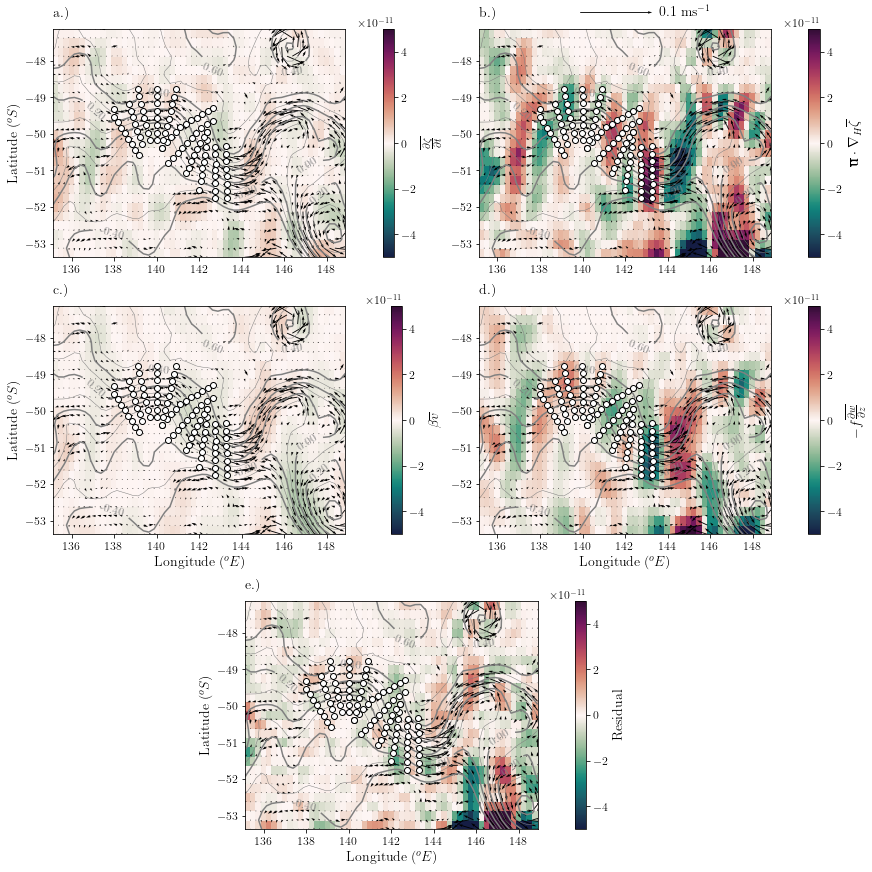

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(12,12))
gs = fig.add_gridspec(ncols=4, nrows=6)
fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, :2])
ax3 = fig.add_subplot(gs[2:4, 2:])
ax4 = fig.add_subplot(gs[4:, 1:3])
ax = fig.get_axes()

vmin, vmax = -5e-11, 5e-11

# local derivative of relative vorticity
pcol = ax[0].pcolor(loni, lati, qgvb.dzetadt.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[0])
cbar.ax.set_ylabel(r'$\overline{\frac{\partial\zeta}{\partial t}}$', fontsize=fs_large)

# mean relative vorticity advection
pcol = ax[1].pcolor(loni, lati, qgvb.ugradzeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[1])
cbar.ax.set_ylabel(r'$\overline{\bf u} \cdot \nabla_H\overline{\zeta}$', fontsize=fs_large)

# mean planetary vorticity advectiom
pcol = ax[2].pcolor(loni, lati, qgvb.betav.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[2])
cbar.ax.set_ylabel(r'$\beta\overline{v}$', fontsize=fs_large)

# time-mean vortex stretching
pcol = ax[3].pcolor(loni, lati, -qgvb.fdwdz.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[3])
cbar.ax.set_ylabel(r'$-f\overline{\frac{\partial w}{\partial z}}$', fontsize=fs_large)

# divergence of horizontal velocity
pcol = ax[4].pcolor(loni, lati,
                    + qgvb.dzetadt.sel(time=timevoy).mean('time')
                    + qgvb.ugradzeta.sel(time=timevoy).mean('time')
                    - qgvb.fdwdz.sel(time=timevoy).mean('time') 
                    + qgvb.betav.sel(time=timevoy).mean('time'),
                    vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
cbar = plt.colorbar(pcol, ax=ax[4])
cbar.ax.set_ylabel(r'Residual', fontsize=fs_large)

iax = 0
for i in range(len(ax)):
        
    # plot sea surface height contours
    ct = ax[i].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'),
                       ssh_contours, colors='gray', linestyles='solid', linewidths=0.5)
    for ib, b in enumerate(ssh_contours):
        if b in ssh_contours[0::2]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[i].clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

    # plot ageostrophic velocity vectors
    quiv = ax[i].quiver(loni, lati, ua.mean('time'), va.mean('time'),
                        units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], color='k')
    if i == 1:
        qk = ax[i].quiverkey(quiv, 0.75, 0.99, 0.1, r'0.1 ms$^{-1}$', labelpos='E', coordinates='figure',
                             fontproperties={'size': fs_large})

    # plot transects and numbers
    for transect in transects.keys():
        istations = np.array(transects[transect]) - 1
        ax[i].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0],
                   'w.-', markersize=fs_small, markeredgecolor='k')

    # plot labels
    ax[i].text(0, 1.05, string.ascii_lowercase[iax] + '.)', transform=ax[i].transAxes, 
               size=fs_large, weight='bold')
    if i in [2, 3, 4]:
        ax[i].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
    if i in [0, 2, 4]:
        ax[i].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
    iax += 1

In [14]:
qgterms = [r'$\overline{\frac{\partial\zeta}{\partial t}}$', r'$\overline{\bf u} \cdot \nabla_H\overline{\zeta}$',
           r'$\beta\overline{v}$', r'$-f\overline{\frac{\partial w}{\partial z}}$', r'Residual']

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and

Text(0, 0.5, 's$^{-2}$')

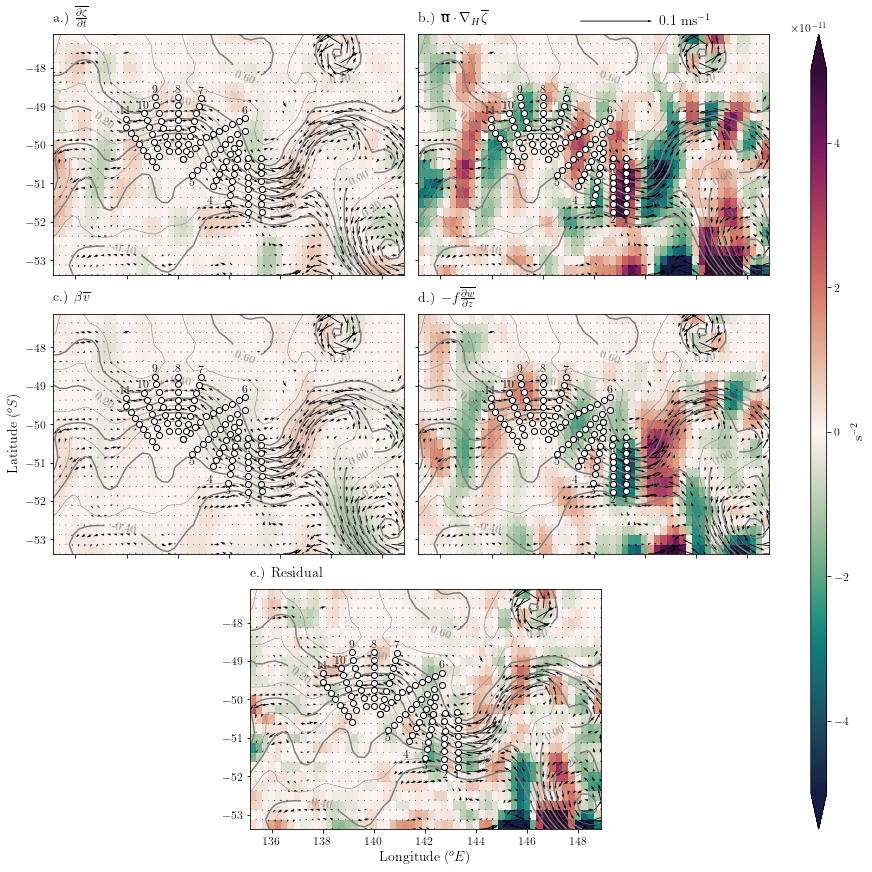

In [15]:
fig = plt.figure(constrained_layout=True, figsize=(12,12))
gs = fig.add_gridspec(ncols=4, nrows=6)
fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, :2])
ax3 = fig.add_subplot(gs[2:4, 2:])
ax4 = fig.add_subplot(gs[4:, 1:3])
ax = fig.get_axes()

vmin, vmax = -5e-11, 5e-11

# local derivative of relative vorticity
pcol = ax[0].pcolor(loni, lati, qgvb.dzetadt.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[0])
# cbar.ax.set_ylabel(r'$\overline{\frac{\partial\zeta}{\partial t}}$', fontsize=fs_large)

# mean relative vorticity advection
pcol = ax[1].pcolor(loni, lati, qgvb.ugradzeta.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[1])
# cbar.ax.set_ylabel(r'$\overline{\bf u} \cdot \nabla_H\overline{\zeta}$', fontsize=fs_large)

# mean planetary vorticity advectiom
pcol = ax[2].pcolor(loni, lati, qgvb.betav.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[2])
# cbar.ax.set_ylabel(r'$\beta\overline{v}$', fontsize=fs_large)

# time-mean vortex stretching
pcol = ax[3].pcolor(loni, lati, -qgvb.fdwdz.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[3])
# cbar.ax.set_ylabel(r'$-f\overline{\frac{\partial w}{\partial z}}$', fontsize=fs_large)

# divergence of horizontal velocity
pcol = ax[4].pcolor(loni, lati,
                    + qgvb.dzetadt.sel(time=timevoy).mean('time')
                    + qgvb.ugradzeta.sel(time=timevoy).mean('time')
                    - qgvb.fdwdz.sel(time=timevoy).mean('time') 
                    + qgvb.betav.sel(time=timevoy).mean('time'),
                    vmin=vmin, vmax=vmax, cmap=cmo.cm.curl)
# cbar = plt.colorbar(pcol, ax=ax[4])
# cbar.ax.set_ylabel(r'Residual', fontsize=fs_large)

iax = 0
for i in range(len(ax)):
        
    # plot sea surface height contours
    ct = ax[i].contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'),
                       ssh_contours, colors='gray', linestyles='solid', linewidths=0.5)
    for ib, b in enumerate(ssh_contours):
        if b in ssh_contours[0::2]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[i].clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

    # plot ageostrophic velocity vectors
    quiv = ax[i].quiver(loni, lati, ua.mean('time'), va.mean('time'),
                        units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], color='k')
    if i == 1:
        qk = ax[i].quiverkey(quiv, 0.75, 0.98, 0.1, r'0.1 ms$^{-1}$', labelpos='E', coordinates='figure',
                             fontproperties={'size': fs_large})

    # plot transects and numbers
    for transect in transects.keys():
        istations = np.array(transects[transect]) - 1
        ax[i].plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0],
                   'w.-', markersize=fs_small, markeredgecolor='k')
    ts = {1:2, 2:17, 3:18, 4:34, 5:36, 6:46, 7:64, 8:75, 9:76, 10:90, 11:93}
    for its in ts.keys():
        spacing = 0.2 if its > 5 else -0.2
        ax[i].text(s=str(its), x=ctd['lon'][ts[its],0], y=ctd['lat'][ts[its],0]+spacing, 
                      ha='center', va='center', fontsize=fs_small)
        
    # plot labels
    ax[i].text(0, 1.05, string.ascii_lowercase[iax] + '.) ' + qgterms[iax], transform=ax[i].transAxes, 
               size=fs_large, weight='bold')
    if i in [4]:#[2, 3, 4]:
        ax[i].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
    else:
        plt.setp(ax[i].get_xticklabels(), visible=False)
    if i not in [0, 2, 4]:
        plt.setp(ax[i].get_yticklabels(), visible=False)
    ax[2].set_ylabel(r'Latitude ($^oS$)', fontsize=fs_large)
    iax += 1
    
cbar = fig.colorbar(pcol, ax=ax, aspect=50, extend='both')
cbar.ax.set_ylabel(r's$^{-2}$', fontsize=fs_large)

In [16]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '08_qg-vorticity-balance-terms' + extension),
                   transparent=True)

In [17]:
# print(qgvb_ctd['fdwdz'])
# advrv = qgvb_ctd['ugradzeta']

Rsquared(qgvb_ctd['fdwdz'], qgvb_ctd['ugradzeta'])


(<xarray.DataArray 'ugradzeta' ()>
 array(0.87102179),
 poly1d([ 1.19787017e+00, -8.77437279e-13]))

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


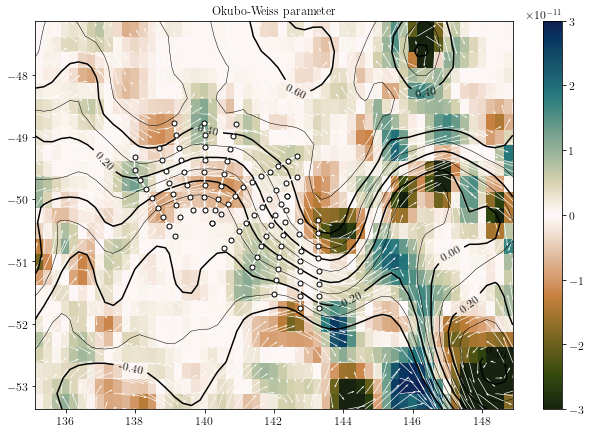

In [18]:
fig, ax = plt.subplots(figsize=(9, 6), sharex=True)
fig.tight_layout()

# plot relative vorticity field
# vmin, vmax = Wcenter + W0 - 1e-12, Wcenter + W0 + 1e-12
vmin, vmax = -3e-11, 3e-11
axis=0
pcol = ax.pcolor(loni, lati, qgvb.ow.sel(time=timevoy).mean('time'), 
                       vmin=vmin, vmax=vmax, cmap=cmo.cm.tarn)
plt.colorbar(pcol)
ax.set_title('Okubo-Weiss parameter')

# plot dynamic height contours
ct = ax.contour(loni, lati, ssh.adt.sel(time=timevoy).mean('time'),
                ssh_contours, colors='k', linestyles='solid', linewidths=0.5)
for ib, b in enumerate(ssh_contours):
    if b in ssh_contours[0::2]:
        zc = ct.collections[ib]
        plt.setp(zc, linewidth=1.5)
ax.clabel(ct, ssh_contours[0::2], inline=1, fontsize=fs_small, fmt='%.2f')

quiv = ax.quiver(loni, lati, ssh.ugos.sel(time=timevoy).mean('time'), ssh.vgos.sel(time=timevoy).mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='w')

# plot transects
for transect in transects.keys():
    istations = np.array(transects[transect]) - 1
    ax.plot(ctd['lon'][istations, 0], ctd['lat'][istations, 0], 'w.-', markersize=10, markeredgecolor='k')



In [19]:
# if savefig:
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '11_okubo-weiss_parameter' + extension),
#                    transparent=True)